# XGBoost model for Bike sharing dataset

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# deep learning libraries
import xgboost as xgb
import graphviz

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import

In [3]:
DATADIR = '../data/bike/'
MODELDIR = '../checkpoints/bike-sharing/xgb/'

data_path = os.path.join(DATADIR, 'bike-sharing-processed.csv')
data = pd.read_csv(data_path)

In [4]:
data.set_index('date', inplace=True)
data.sort_index(inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
date,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


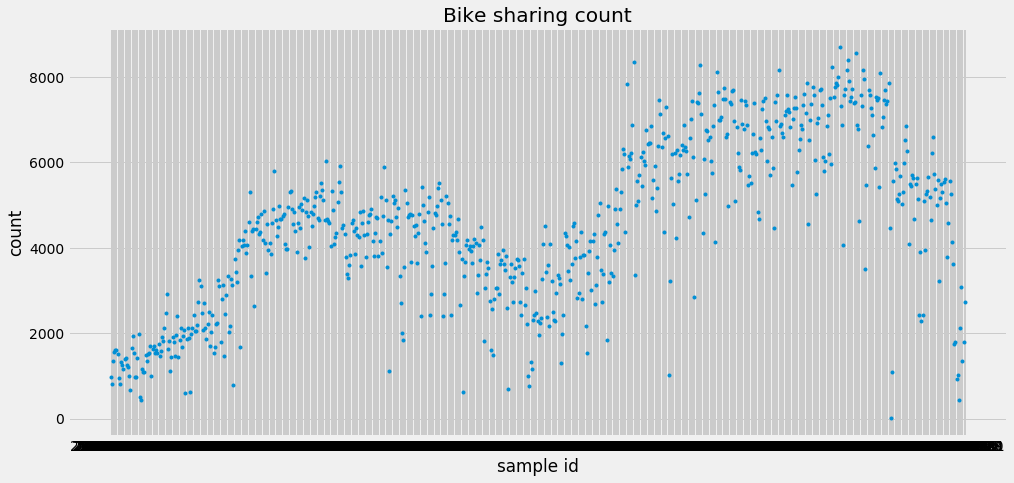

In [7]:
plt.plot(data.cnt, '.')
plt.title('Bike sharing count')
plt.xlabel('sample id')
plt.ylabel('count')
plt.show()

## 2. Train test split

In [8]:
y = data[['cnt']].copy()
X = data.drop(columns=['cnt'], axis=1)

print(f'X and y shape:')
print(X.shape, y.shape)

X and y shape:
(731, 12) (731, 1)


In [10]:
# date selection
datelist = data.index.unique()

# two month data for testset
print(f'Test start date: {datelist[-61]}')

Test start date: 2012-11-01


In [13]:
# Train test split : last 60 days for test set

X_train = X[X.index < datelist[-61]]
X_test = X[X.index >= datelist[-61]]

y_train = y[y.index < datelist[-61]]
y_test = y[y.index >= datelist[-61]]

print(f'Size of train and test set respectively:')
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

Size of train and test set respectively:
(670, 12) (61, 12) (670, 1) (61, 1)


## 3. Parameter selection using grid search

In [14]:
def xgb_parameter_selection(X, y, grid_param, xgb_param):

    xgb_grid = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_param, seed=seed), 
                            param_grid=grid_param, cv=3)
    xgb_grid.fit(X, y)
        
    return xgb_grid

### 3.1 Depth and child weight selection

In [15]:
seed = 42

# max depth and child weight selection
grid_param_1 = {'max_depth': [3, 5],
                'min_child_weight': [3, 5, 7]
                }

xgb_param_1 = {'objective' :'reg:linear', 
               'silent' : 1,
               'n_estimators': 100, 
               'learning_rate' : 0.1}

In [16]:
model_1 = xgb_parameter_selection(X_train, y_train, grid_param_1, xgb_param_1)

# print(f'Best estimator : {model_1.best_estimator_}')
print(f'Best parameter : {model_1.best_params_}')
print(f'Best score     : {model_1.best_score_}')

Best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
       subsample=1)
Best parameter : {'max_depth': 5, 'min_child_weight': 7}
Best score     : 0.2972105129489122


/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 3.2 colsample_bytree and subsample selection

In [17]:
# column and sample selection parameter
grid_param_2 = {'colsample_bytree' : [0.7, 1.0],
                'subsample' : [0.8, 1]
                }

xgb_param_2 = {'objective' :'reg:linear', 
               'silent' : 1,
               'max_depth': 5,
               'min_child_weight':7,
               'n_estimators': 100, 
               'learning_rate' : 0.1,
               'eval_metric' : 'mae' }

In [18]:
model_2 = xgb_parameter_selection(X_train, y_train, grid_param_2, xgb_param_2)

print(f'Best parameter : {model_2.best_params_}')
print(f'Best score     : {model_2.best_score_}')

Best parameter : {'colsample_bytree': 0.7, 'subsample': 1}
Best score     : 0.3446978540630942


/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 3.3 gamma selection

In [19]:
# gamma selection
grid_param_3 = {'gamma' : [0, 0.1, 0.2, 5]
                }

xgb_param_3 = {'objective' :'reg:linear', 
               'silent' : 1,
               'max_depth': 5,
               'min_child_weight': 7,
               'n_estimators': 100, 
               'learning_rate' : 0.1,
               'colsample_bytree' : 0.7,
               'subsample' : 1}

In [20]:
model_3 = xgb_parameter_selection(X_train, y_train, grid_param_3, xgb_param_3)

print(f'Best parameter : {model_3.best_params_}')
print(f'Best score     : {model_3.best_score_}')

Best parameter : {'gamma': 0}
Best score     : 0.3446978540630942


/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 3.4 learning rate

In [21]:
# learning_rate selection
grid_param_4 = {'learning_rate' : [0.1, 0.01, 0.001]
                }

xgb_param_4 = {'objective' :'reg:linear', 
               'silent' : 1,
               'max_depth': 5,
               'min_child_weight': 7,
               'n_estimators': 100, 
               'learning_rate' : 0.1,
               'colsample_bytree' : 0.7,
               'subsample' : 1,
               'gamma' : 0}

In [22]:
model_4 = xgb_parameter_selection(X_train, y_train, grid_param_4, xgb_param_4)

print(f'Best parameter : {model_4.best_params_}')
print(f'Best score     : {model_4.best_score_}')

Best parameter : {'learning_rate': 0.1}
Best score     : 0.3446978540630942


/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 4. Final model training

In [30]:
final_param = {'objective' :'reg:linear', 
               'silent' : 1,
               'max_depth': 5,
               'min_child_weight': 7,
               'n_estimators': 100, 
               'learning_rate' : 0.1,
               'colsample_bytree' : 0.7,
               'subsample' : 1,
               'gamma' : 0,
               'eval_metric' : 'mae'}

In [33]:
def xgb_final(X_train, y_train, param, MODELDIR):

    model = xgb.XGBRegressor(**param)

    model.fit(X_train, y_train, verbose=True)
    
    # directory for saving model 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
        
    model.save_model(os.path.join(MODELDIR, 'xgb-v1.model'))
    
    return model

In [34]:
model = xgb_final(X_train, y_train, final_param, MODELDIR)

## 5. Model evaluation

In [42]:
def model_evaluation(X_train, X_test, y_train, y_test):
    
    # predict and tranform to original scale
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_nrmse = train_rmse/np.std(y_train.values)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_nrmse = test_rmse/np.std(y_test.values)

    print(f'Training MAE: {np.round(train_mae, 3)}')
    print(f'Trainig NRMSE: {np.round(train_nrmse, 3)}')
    print()

    print(f'Test MAE: {np.round(test_mae)}')
    print(f'Test NRMSE: {np.round(test_nrmse)}')
    
    return y_train_pred, y_test_pred

In [43]:
y_train_pred, y_test_pred = model_evaluation(X_train, X_test, y_train, y_test)

Training MAE: 200.654
Trainig NRMSE: 0.14

Test MAE: 780.0
Test NRMSE: 1.0


## 6. Result plotting

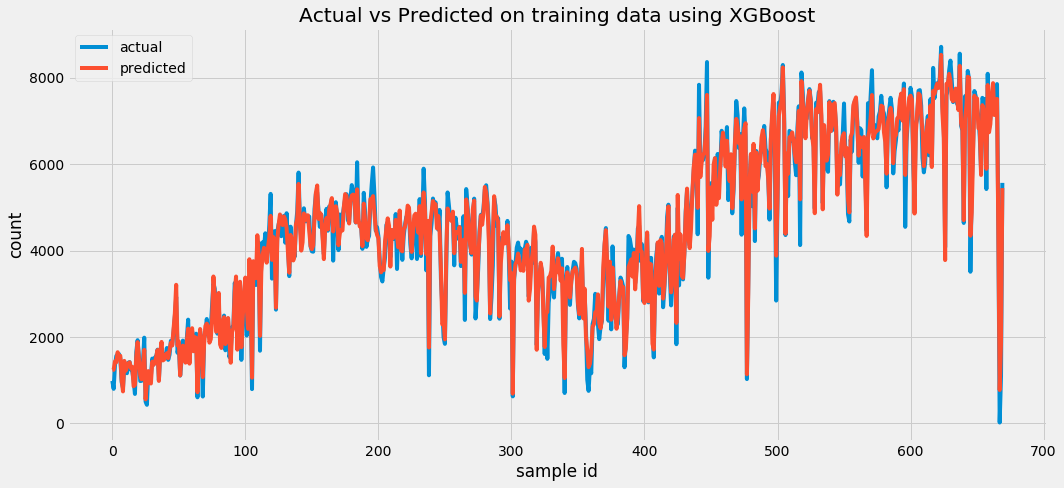

In [44]:
plt.plot(y_train.values, label='actual')
plt.plot(y_train_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on training data using XGBoost')
plt.legend()
plt.tight_layout()
plt.show()

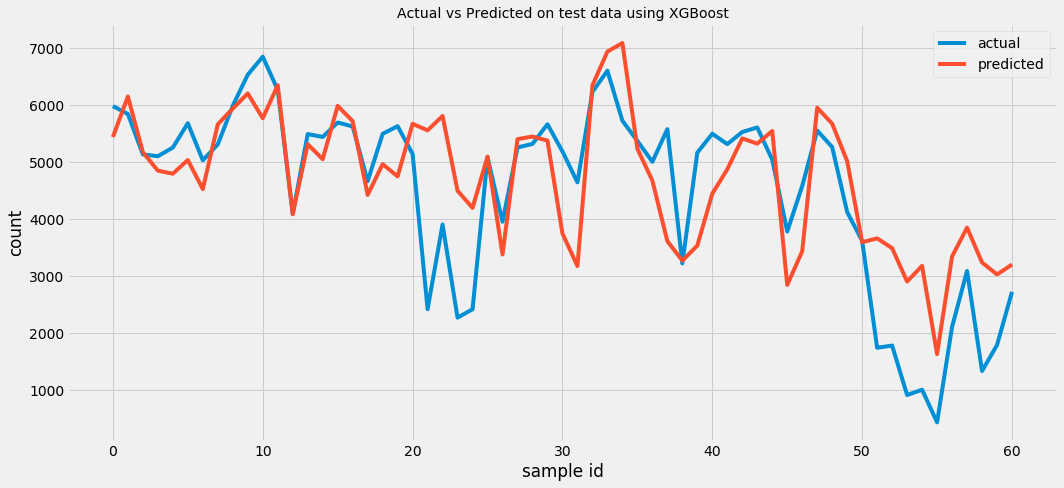

In [45]:
plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using XGBoost', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Variable importance

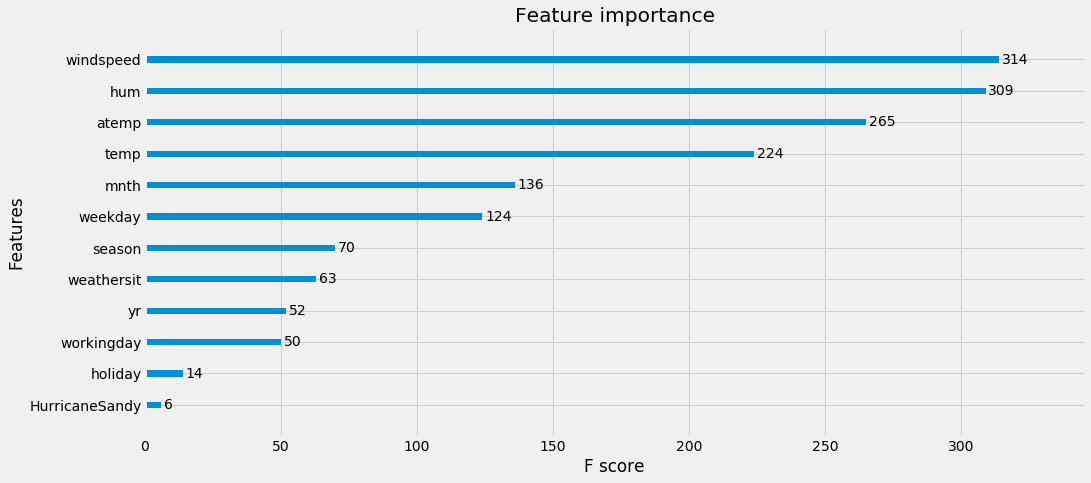

In [46]:
xgb.plot_importance(model)
plt.show()